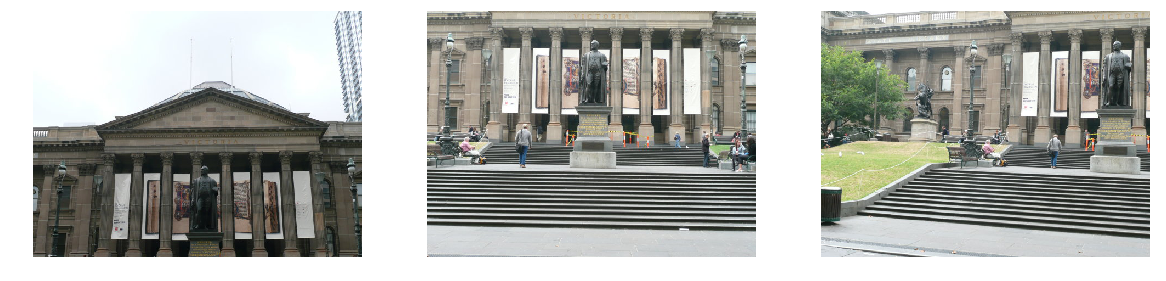

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.feature import peak_local_max
import random 
"""
Read a set of images for Panorama stitching
"""
%matplotlib inline
path = '../Data/Train/Set1/'
img1 = plt.imread(path+'1.jpg')
img2 = plt.imread(path+'2.jpg')
img3 = plt.imread(path+'3.jpg')

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.axis('off')
plt.imshow(img1)
plt.subplot(132)
plt.axis('off')
plt.imshow(img2)
plt.subplot(133)
plt.axis('off')
plt.imshow(img3)

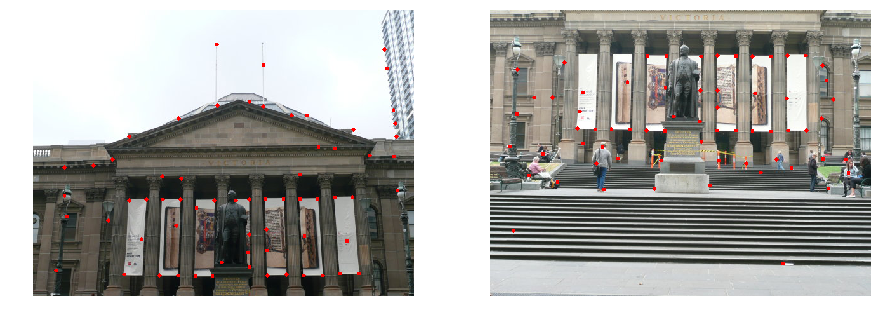

In [2]:
def harris_corner(img):
    
    img_temp = img.copy()
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
#     Rs = cv2.cornerMinEigenVal(gray_img,2,3)
    Rs = cv2.cornerHarris(gray_img,2,3,k=0.04)
    t = Rs<0.01*Rs.max()
    m = Rs>0.01*Rs.max()
    Rs[t] = 0
    corners = np.where(m)
    img_temp[corners]=[255,0,0]
    
    return img_temp,Rs,corners

def anms(Cmap,corners,image):
    img = image.copy()
    C = Cmap.copy()
    locmax = peak_local_max(C,min_distance=20)

    n_strong = 65
    
    r = [np.Infinity for i in range(n_strong)]
    x=np.zeros((n_strong,1))
    y=np.zeros((n_strong,1))
    ed=0
    for i in range(n_strong):
        for j in range(n_strong):
            if(C[locmax[j][0],locmax[j][1]] > C[locmax[i][0],locmax[i][1]]):
                ed = (locmax[j][0]-locmax[i][0])**2 + (locmax[j][1]-locmax[i][1])**2
            if ed<r[i]:
                r[i] = ed
                x[i] = locmax[i][0]
                y[i] = locmax[i][1]
                cv2.circle(img,(y[i],x[i]),3,255,-1)
    return x,y,img


#Harris Corners
img1_corner,map1,corners1 = harris_corner(img1)
x1,y1,img1_corner = anms(map1,corners1,img1)


img2_corner,map2,corners2 = harris_corner(img2)
x2,y2,img2_corner = anms(map2,corners2,img2)


x1 = np.int0(x1.reshape(1,len(x1)))[0]
x2 = np.int0(x2.reshape(1,len(x2)))[0]
y1 = np.int0(y1.reshape(1,len(y1)))[0]
y2 = np.int0(y2.reshape(1,len(y2)))[0]

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.axis('off')
plt.imshow(img1_corner)
plt.subplot(122)
plt.axis('off')
plt.imshow(img2_corner)


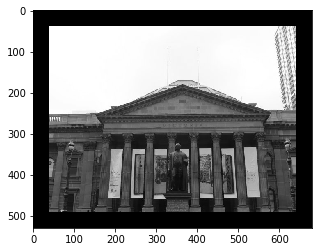

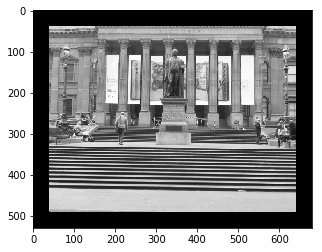

In [3]:
def feature_des(img,x_best,y_best):
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    top = 40
    bottom = top
    left = 40
    right = left 
    dst = cv2.copyMakeBorder(gray_img, top, bottom, left, right, cv2.BORDER_CONSTANT, None, [0])
    plt.figure()
    plt.imshow(dst,cmap='gray')
    features = []
    for i in range(len(x_best)):
        patch = dst[x_best[i]+20:x_best[i]+60,y_best[i]+20:y_best[i]+60]
        patch = cv2.GaussianBlur(patch,(5,5),cv2.BORDER_DEFAULT)
        patch = cv2.resize(patch, (8,8), interpolation = cv2.INTER_AREA)
        feature = np.reshape(patch, (64, ))
        mean = np.mean(feature)
        std = np.std(feature)
        feature = (feature - mean)/std
        features.append(feature)
    return features,patch

features1,patch1 = feature_des(img1,x1,y1)
features2,patch2 = feature_des(img2,x2,y2)

In [4]:
"""
Feature Matching
Save Feature Matching output as matching.png
"""
def feature_match(features1,features2,x1,y1,x2,y2,img1,img2):
    features1 = np.array(features1,dtype='float32')
    features2 = np.array(features2,dtype='float32')

    bf = cv2.BFMatcher()
    rawMatches = bf.knnMatch(features1,features2,2)


    matches = []
    good = []
    c=0
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.90:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            good.append([m[0]])
            c = c+1

    print(c)
    corners1 = []
    corners2 = []
    for i in range(len(x1)):
        corners1.append([x1[i],y1[i]])

    for i in range(len(x2)):
        corners2.append([x2[i],y2[i]])

    pts1 = np.float32(corners1)
    pts2 = np.float32(corners2)
    pts1 = np.reshape(pts1,(len(x1),2))
    pts2 = np.reshape(pts2,(len(x2),2))

    kp1=[]
    kp2=[]
    for i in range(len(pts1)):
        kp1.append(cv2.KeyPoint(pts1[i][1], pts1[i][0], 5))
        kp2.append(cv2.KeyPoint(pts2[i][1], pts2[i][0], 5))

    img = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

    plt.figure(figsize=(15,15))
    plt.imshow(img)


    c = 0
    pts1f = []
    pts2f = []

    pts1t = []
    pts2t = []


    for mat in good:
        pts1f.append([kp1[mat[0].queryIdx].pt[1],kp1[mat[0].queryIdx].pt[0]])
        pts2f.append([kp2[mat[0].trainIdx].pt[1],kp2[mat[0].trainIdx].pt[0]])
        pts1t.append([kp1[mat[0].queryIdx].pt[0],kp1[mat[0].queryIdx].pt[1]])
        pts2t.append([kp2[mat[0].trainIdx].pt[0],kp2[mat[0].trainIdx].pt[1]])

    pts1f = np.float32(np.reshape(pts1f,(len(pts1f),2)))
    pts2f = np.float32(np.reshape(pts2f,(len(pts2f),2)))
    pts1t = np.float32(np.reshape(pts1t,(len(pts1t),2)))
    pts2t = np.float32(np.reshape(pts2t,(len(pts2t),2)))

    return pts1f,pts2f,pts1t,pts2t


# print(pts2f[1:10])
# print("\n\n Points")
# print(pts2)
# print(pts1f[1:10])
# img = plt.imread(path+'2.jpg')
# plt.figure()
# img1 = img.copy()
# print(img[0,0])
# for i in pts2f:
#     i = np.int0(i)
#     cv2.circle(img1,(i[1],i[0]),3,255,-1)
    
# plt.imshow(img1)

In [5]:
"""
Refine: RANSAC, Estimate Homography
"""
def ransac(pts1, pts2, N=10, t=0.95, thresh=60.0):

    totalPoints = len(pts1)

    bestH = np.zeros((3,3))
    maxInliers = 0
    
    for j in range(N):
        index = []
        randFour = [np.random.randint(0,totalPoints) for i in range(4)]
#         print(randFour)
        p1 = pts1[randFour]
        p2 = pts2[randFour]
#         H = homography(p1,p2)
        H = cv2.getPerspectiveTransform( np.float32(p1), np.float32(p2) )
        inLiers = 0
        for ind in range(totalPoints):
            source = pts1[ind]
            target = np.array([pts2[ind][0],pts2[ind][1]])
            pred = np.dot(H, np.array([source[0],source[1],1]))
#             print(pred[2])
            predx = pred[0]/pred[2]
            predy = pred[1]/pred[2]
            pred = np.array([predx,predy])
            pred = np.float32([point for point in pred])
#             print("Prediction",pred)
#             print("\n")
#             print("Target",target)
#             print(np.linalg.norm(target-pred))
            if np.linalg.norm(target-pred) < thresh:
                inLiers += 1
                index.append(ind)

        if maxInliers < inLiers:
            maxInliers = inLiers
            bestH = H
            if inLiers > t*totalPoints:
                break
    return bestH,index



35
9
[[ 7.89618003e-01 -5.99140384e-02  2.61782006e+01]
 [-1.83705768e-02  7.55226554e-01 -1.55874314e+02]
 [-1.77627035e-04 -3.25520783e-04  1.00000000e+00]]
1
1


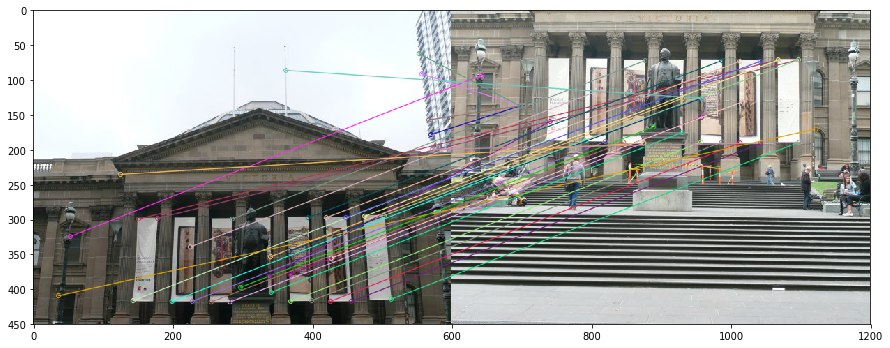

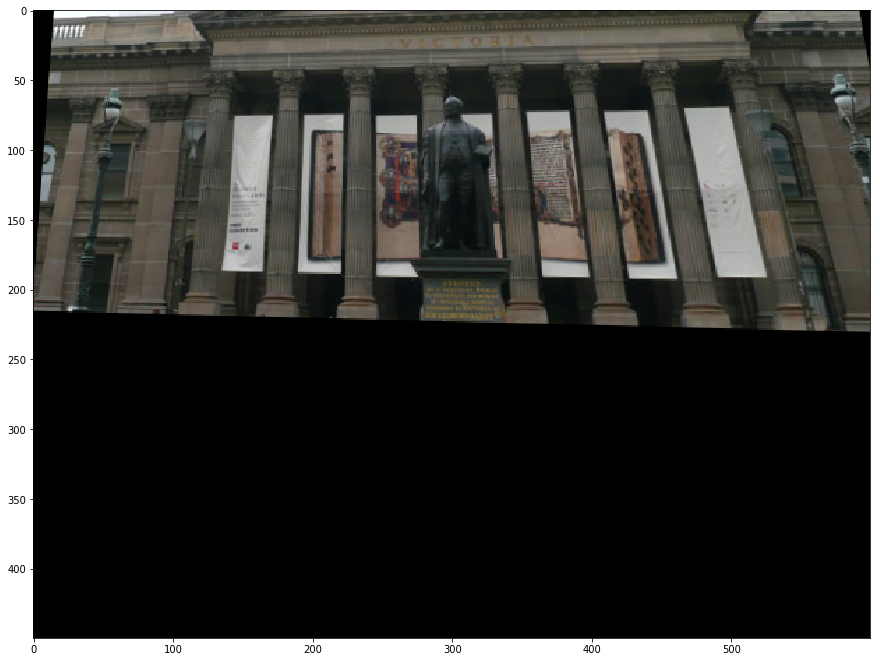

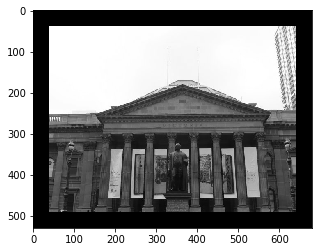

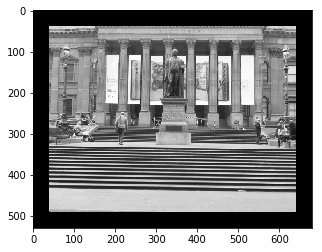

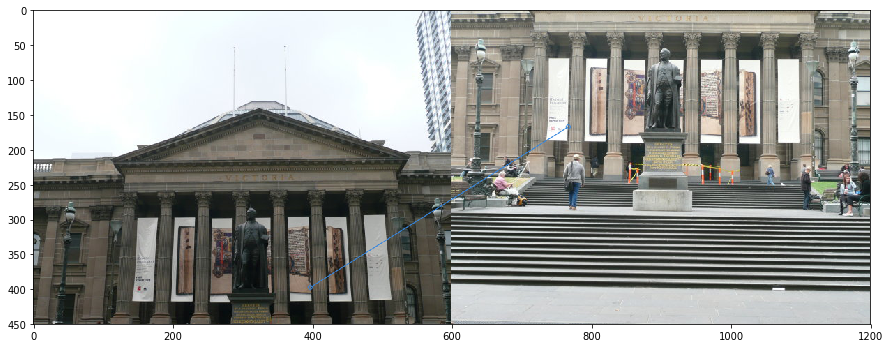

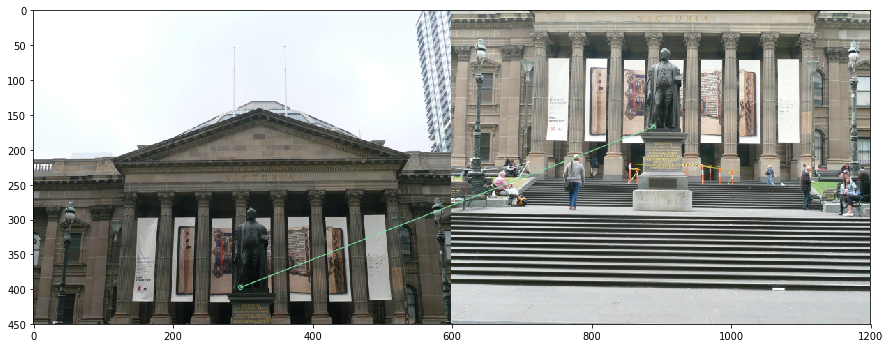

In [6]:
pts1f,pts2f,pts1t,pts2t = feature_match(features1,features2,x1,y1,x2,y2,img1,img2)
H,index = ransac(pts1t,pts2t)
print(len(index))

pts1n = []
pts2n = []
x1n=[]
x2n=[]
y1n=[]
y2n=[]
for i in index:
    pts1n.append(pts1f[i])
    x1n.append(np.int0(pts1f[i][0]))
    y1n.append(np.int0(pts1f[i][0]))
    pts2n.append(pts2f[i])
    x2n.append(np.int0(pts2f[i][0]))
    y2n.append(np.int0(pts2f[i][0]))
    
H = np.float64([pt for pt in H])
print(H)

## -------------------Without Ransac------------------
# randFour = [np.random.randint(0,len(pts1f)) for i in range(4)]
# print(randFour)
# p1 = pts1f[randFour]
# p2 = pts2f[randFour]
# H = cv2.getPerspectiveTransform( np.float32(p1), np.float32(p2) )
# img1_temp  = img1.copy()
# img2_temp = img2.copy()
# for i,j in zip(p1,p2):
#     i = np.int0(i)
#     j = np.int0(j)
#     cv2.circle(img1_temp,(i[1],i[0]),5,255,-1)
#     cv2.circle(img2_temp,(j[1],j[0]),5,255,-1)
    
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.axis('off')
# plt.imshow(img1_temp)
# plt.subplot(122)
# plt.axis('off')
# plt.imshow(img2_temp)

# result = cv2.warpPerspective(img1, H,(img1.shape[1], img1.shape[0]))
# plt.figure(figsize=(15,15))
# plt.imshow(result)
##--------------------------------------------------------



#--------------------
result = cv2.warpPerspective(img1, H,(img1.shape[1], img1.shape[0]))
plt.figure(figsize=(15,15))
plt.imshow(result)

# result[0:img2.shape[0], 0:img2.shape[1]] = img2

features1,patch1 = feature_des(img1,x1n,y1n)
features2,patch2 = feature_des(img2,x2n,y2n)
pts1f,pts2f,pts1t,pts2t = feature_match(features1,features2,x1n,y1n,x2n,y2n,img1,img2)
features1 = np.array(features1,dtype='float32')
features2 = np.array(features2,dtype='float32')


# kp1n=[]
# kp2n=[]
# for i in range(len(pts1n)):
#     kp1n.append(cv2.KeyPoint(pts1n[i][1], pts1n[i][0], 5))
#     kp2n.append(cv2.KeyPoint(pts2n[i][1], pts2n[i][0], 5))
# img = cv2.drawMatchesKnn(img1,kp1n,img2,kp2n,good,None,flags=2)
# plt.figure(figsize=(15,15))
# plt.imshow(img)
# # print(H)
# plt.figure()
# result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
